In [1]:
import os
import scipy.io as sio
import scipy.misc as smisc
import numpy as np
import re as regexp
import math
import matplotlib.pyplot as plt
import scipy
import skimage
import csv

from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

import scipy.io
import time
import glob,os
import cv2
from scipy import optimize
from pylab import *
import imutils

## Visulize data

Text(0.5, 1.0, 'real space integration')

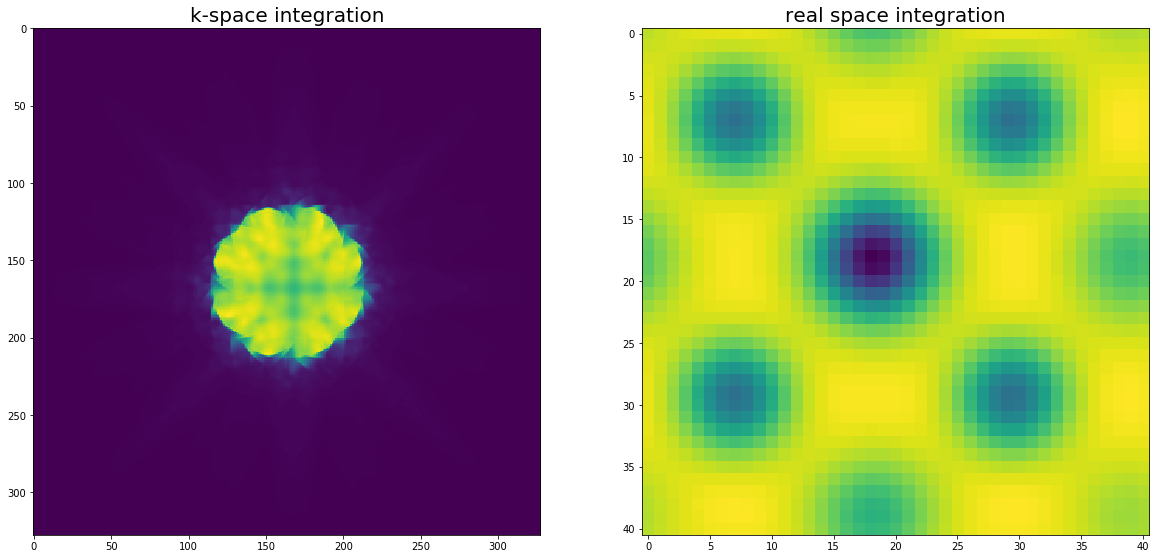

In [2]:
folder = '/srv/home/chenyu/CNN/Data/STO_100nm/2_2/2.0_2.0mrad/'
data = np.load(folder + 'STO_13_110pmss.npy')
fig = plt.figure(figsize=(20,10))
fig.add_subplot(121)
plt.imshow(np.sum(np.sum(data,axis=0),axis=0))
plt.title('k-space integration',fontsize=20)
fig.add_subplot(122)
plt.imshow(np.sum(np.sum(data,axis=2),axis=2))
plt.title('real space integration',fontsize=20)

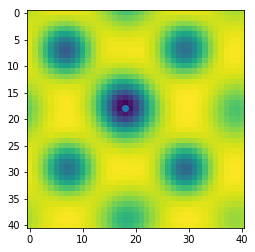

In [33]:
# Real space integration center = (18,18)
plt.imshow(np.sum(np.sum(data,axis=2),axis=2))
plt.scatter(18,18)

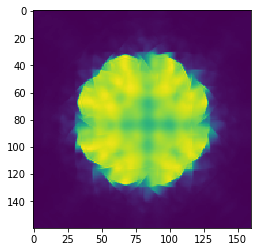

In [34]:
# Rec space crop range = 164 +/- 80
PACBED = np.sum(np.sum(data,axis=0),axis=0)
plt.imshow(PACBED[164-80:164+80,164-80:164+80])

## Select noise level

In [130]:
# Exp dataset from one single frame
# exp = np.load('/srv/home/chenyu/DEbackup/033119/S8/PACBED_stack_radius_1.npy')
exp = np.load('/srv/home/chenyu/DEbackup/033119/S8/npy/S8_10000.npy')
# Sim data from one single frame, noiseless
PEAK = 5
sim = data[18,18,164-80:164+80,164-80:164+80]
sim_noisy = np.random.poisson(sim / np.amax(sim) * PEAK)

Now use peak=10 to normalzie simulation images before applying Poisson noise and averaging. Histogram looks similar, simulation image shows more DF features, probably because there are more averaging in experiment due to sample drift.

Text(0, 0.5, 'Occurance')

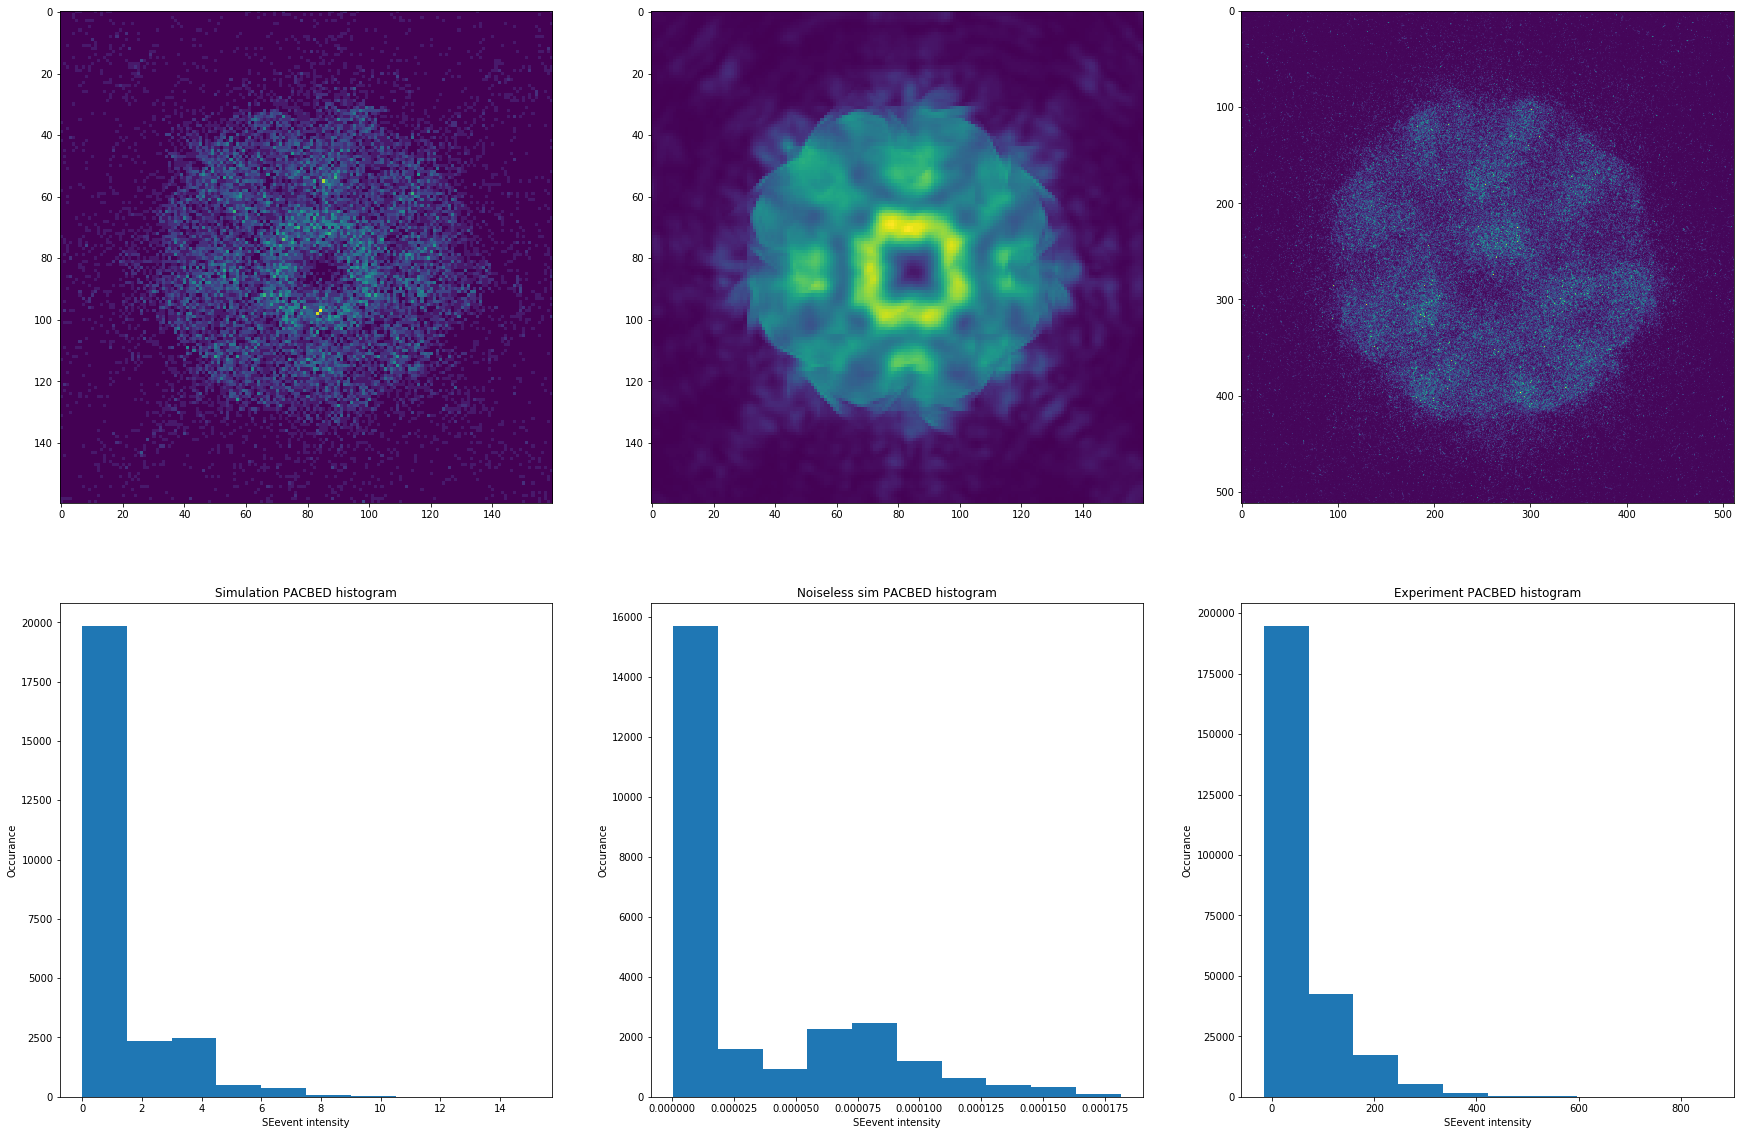

In [131]:
fig = plt.figure(figsize=(30,20))
fig.add_subplot(231)
plt.imshow(sim_noisy)

fig.add_subplot(232)
plt.imshow(sim)

fig.add_subplot(233)
plt.imshow(exp)

fig.add_subplot(234)
plt.hist(sim_noisy.reshape(-1))
plt.title('Simulation PACBED histogram')
plt.xlabel('SEevent intensity')
plt.ylabel('Occurance')

fig.add_subplot(235)
plt.hist(sim.reshape(-1))
plt.title('Noiseless sim PACBED histogram')
plt.xlabel('SEevent intensity')
plt.ylabel('Occurance')

fig.add_subplot(236)
plt.hist(exp.reshape(-1))
plt.title('Experiment PACBED histogram')
plt.xlabel('SEevent intensity')
plt.ylabel('Occurance')

In [119]:
radius = 7
PEAK = 5
expMask = create_circular_mask(radius*2+1,radius*2+1,center=[radius,radius])
px_list = np.nonzero(expMask)
x = 18
y = 18
# row for non-zero pixels
row_list = px_list[0] + y - radius
col_list = px_list[1] + x - radius
PACBED = np.zeros((160,160))
PACBED_noiseless = np.zeros((160,160))
for i in range(len(row_list)):
    sim = data[row_list[i],col_list[i],164-80:164+80,164-80:164+80]
    PACBED_noiseless = PACBED_noiseless + sim
    sim_noisy = np.random.poisson(sim / np.amax(sim) * PEAK)
    PACBED = PACBED + sim_noisy

Text(0, 0.5, 'Occurance')

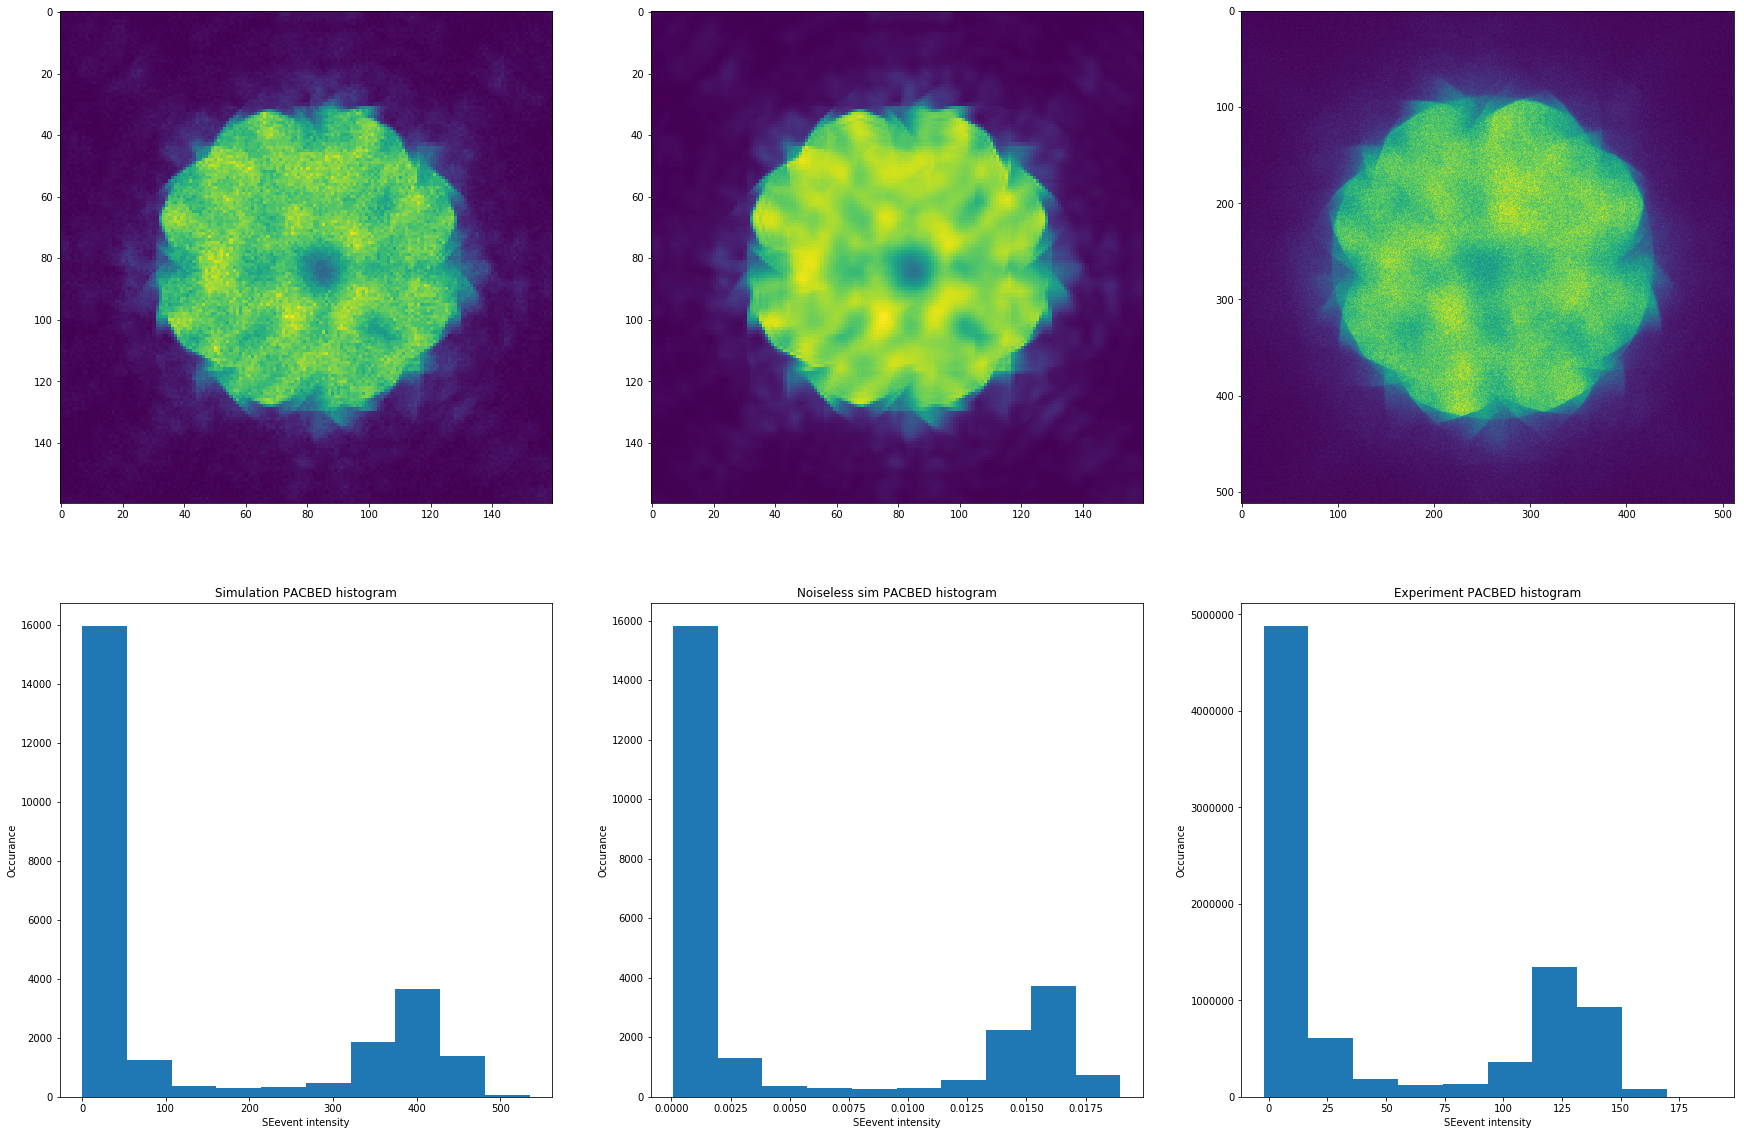

In [120]:
fig = plt.figure(figsize=(30,20))
fig.add_subplot(231)
plt.imshow(PACBED)

fig.add_subplot(232)
plt.imshow(PACBED_noiseless)

exp = np.load('/srv/home/chenyu/DEbackup/033119/S8/PACBED_stack_radius_7.npy')
fig.add_subplot(233)
plt.imshow(exp[:,:,10])

fig.add_subplot(234)
plt.hist(PACBED.reshape(-1))
plt.title('Simulation PACBED histogram')
plt.xlabel('SEevent intensity')
plt.ylabel('Occurance')

fig.add_subplot(235)
plt.hist(PACBED_noiseless.reshape(-1))
plt.title('Noiseless sim PACBED histogram')
plt.xlabel('SEevent intensity')
plt.ylabel('Occurance')

fig.add_subplot(236)
plt.hist(exp.reshape(-1))
plt.title('Experiment PACBED histogram')
plt.xlabel('SEevent intensity')
plt.ylabel('Occurance')

## Full script generating PACBED for CNN

In [133]:
# target at 110pm source size only for now
folder = '/srv/home/chenyu/CNN/Data/STO_100nm/2_2/2.0_2.0mrad/'
target = '/srv/home/chenyu/CNN/Data/STO_100nm_PACBED/2_2/'
PEAK = 5

# loop for different thickness level
for slc in range(52):
    filename = 'STO_' + str(slc) + '_110pmss.npy'
    data = np.load(folder + filename)
    # loop for different integration center
    for ix in range(3):
        for iy in range(3):
            # loop for different integration radii
            for ir in range(11):
                
                radius = ir + 1
                expMask = create_circular_mask(radius*2+1,radius*2+1,center=[radius,radius])
                px_list = np.nonzero(expMask)
                x = 18 - 1 + ix
                y = 18 - 1 + iy
                # row for non-zero pixels
                row_list = px_list[0] + y - radius
                col_list = px_list[1] + x - radius
                PACBED = np.zeros((160,160))
                
                for i in range(len(row_list)):
                    sim = data[row_list[i],col_list[i],164-80:164+80,164-80:164+80]
                    sim_noisy = np.random.poisson(sim / np.amax(sim) * PEAK)
                    PACBED = PACBED + sim_noisy
                    
                np.save(target + 'STO_' + str(slc) + '_' + str(ix) + '_' + str(iy) + '_' + str(radius) + '.npy',PACBED)

KeyboardInterrupt: 

In [73]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

## Sanity check: #FP convergence

In [137]:
CBED_2FP = np.load('/srv/home/chenyu/CNN/Data/STO_100nm/Conv_test_2FP/0.0_0.0mrad/depth0_slice17_X1_Y1_FPavg.npy')
CBED_10FP = np.load('/srv/home/chenyu/CNN/Data/STO_100nm/Conv_test_10FP/0.0_0.0mrad/depth0_slice17_X1_Y1_FPavg.npy')

In [138]:
CBED_2FP.shape

(328, 328, 1)

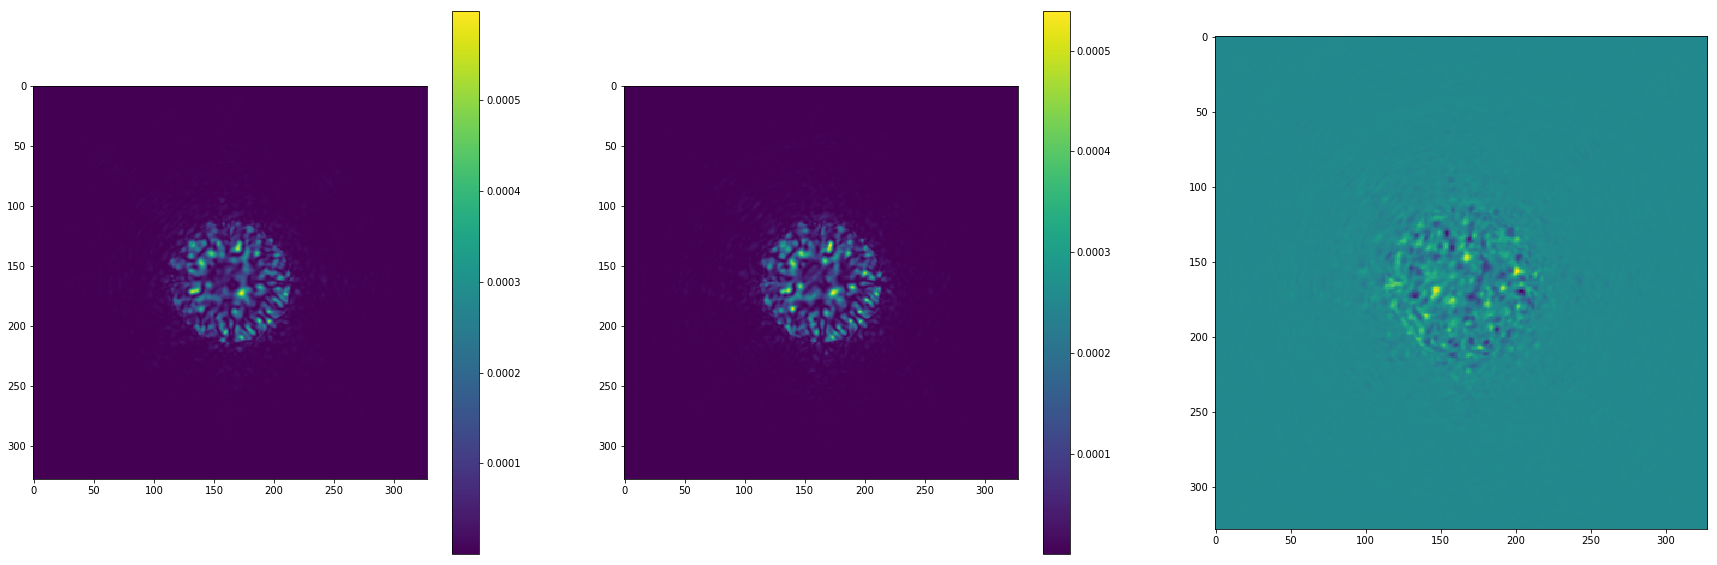

In [143]:
fig = plt.figure(figsize=(30,10))
fig.add_subplot(131)
plt.imshow(CBED_2FP[:,:,0])
plt.colorbar()

fig.add_subplot(132)
plt.imshow(CBED_10FP[:,:,0])
plt.colorbar()

fig.add_subplot(133)
plt.imshow(CBED_10FP[:,:,0] - CBED_2FP[:,:,0])

(-0.5, 327.5, 327.5, -0.5)

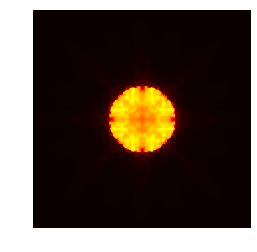

In [14]:
folder = '/srv/home/chenyu/CNN/Data/STO_100nm/0_0/0.0_0.0mrad/'
data = np.load(folder + 'STO_18_110pmss.npy')
PACBED = np.sum(np.sum(data,axis=0),axis=0)
plt.imshow(PACBED,cmap='hot')
plt.clim([np.amin(PACBED),1.3*np.amax(PACBED)])
plt.axis('off')